PyTorch GRU based stock prediction model. Inspired by this Medium [article](https://towardsdatascience.com/lstm-time-series-forecasting-predicting-stock-prices-using-an-lstm-model-6223e9644a2f) and this Kaggle [post](https://www.kaggle.com/taronzakaryan/stock-prediction-lstm-using-pytorch) on stock prediction. I wanted to benchmark how a GRU performed compared to the LSTMs used previously.

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

!ls "/content/gdrive/My Drive/GRU Stock Prediction/datasets"

PATH = '/content/gdrive/My Drive/GRU Stock Prediction/datasets/{symbol}'

Mounted at /content/gdrive
TSLA.csv


In [3]:
import os
import math
import random
import time
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

Data shape: (1306, 1)
                 TSLA
2015-07-10  51.830002
2015-07-13  52.431999
2015-07-14  53.130001
2015-07-15  52.627998
2015-07-16  53.335999


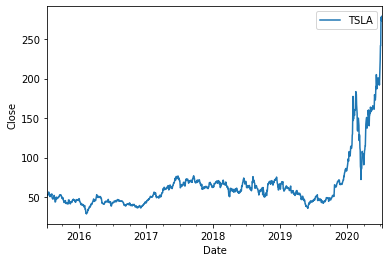

In [4]:
def fetch_df(symbols, dates, scale=True):
    '''
    csv loader and scaler for dataset
    source: https://blog.floydhub.com/gru-with-pytorch/
    '''
    df = pd.DataFrame(index=dates)
    label_scalers = {}

    for symbol in symbols:
        df_temp = pd.read_csv(PATH.format(symbol=symbol+'.csv'), index_col='Date', parse_dates=True, usecols=['Date', 'Close'], na_values=['nan'])
        df_temp = df_temp.rename(columns={'Close': symbol})
        df = df.join(df_temp)
        if scale:
            # normalize input features
            sc = MinMaxScaler()
            label_sc = MinMaxScaler()
            data = sc.fit_transform(df_temp.values) 

            # store scaling for the labels when evaluating output
            label_sc.fit(df.iloc[:,0].values.reshape(-1,1))
            label_scalers[symbol] = label_sc

    return df

symbols = ['TSLA']
dates = pd.date_range(start='2015-07-10',end='2020-07-10',freq='B')
df = fetch_df(symbols, dates)

print('Data shape:',df.shape)
print(df.head(5))

df = df.fillna(method='ffill')
df.interpolate().plot()
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

Split into test and training sets. 

In [5]:
# def min_max_scalar(x, feature_range=(0,1), dim=0):
#     '''
#     replicates behaviour of sklearn.preprocessing.MinMaxScalar
#     '''
#     x_std = (x - x.min(dim, keepdim=True).values) / (x.max(dim, keepdim=True).values - x.min(dim, keepdim=True).values)
#     x_scaled = x_std * (feature_range[1] - feature_range[0]) + feature_range[0]
#     return x_scaled, x_std


def symbol_loader(df, symbol, lookback=20, test_split=0.2, shuffle=False):
    '''
    convert df of symbol close prices to a tensor array with (n-lookback) sequences of `lookback`
    '''
    price = torch.tensor(df[symbol].values)
    T = len(price) - lookback
    data = torch.zeros(T, lookback)

    for i in range(T):
        data[i,:] = price[i:i+lookback]
    
    test_size = int(test_split * T)
    train_size = T - test_size

    idx = list(range(T))

    if shuffle:
        random.shuffle(idx)

    print(data.shape)
    data = data.view(T, -1, 1)
    print(data.shape)

    x_train = data[idx[:train_size], :-1, :]
    y_train = data[idx[:train_size], -1, :]
    x_test = data[idx[train_size:test_size+train_size], :-1, :]
    y_test = data[idx[train_size:test_size+train_size], -1, :]

    return x_train, y_train, x_test, y_test, idx


lookback = 20
x_train, y_train, x_test, y_test, idx = symbol_loader(df, 'TSLA', lookback)

print('x_train.shape:', x_train.shape)
print('y_train.shape:', y_train.shape)
print('x_test.shape:', x_test.shape)
print('y_test.shape:', y_test.shape)

torch.Size([1286, 20])
torch.Size([1286, 20, 1])
x_train.shape: torch.Size([1029, 19, 1])
y_train.shape: torch.Size([1029, 1])
x_test.shape: torch.Size([257, 19, 1])
y_test.shape: torch.Size([257, 1])


In [6]:
class GRUNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, drop=0.2, bi=False):
        super(GRUNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # n_layers stacked GRU cells - dropout applied except last layer
        self.gru = nn.GRU(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop, bidirectional=bi)
        # ReLU activation
        self.relu = nn.ReLU()
        # fully connected final layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device)
        return hidden


    def forward(self, x, h):
        x, h = self.gru(x,h)
        x = self.fc(self.relu(x[:,-1]))
        return x, h

class LSTMNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, output_dim, drop=0.2):
        super(LSTMNet, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, batch_first=True, dropout=drop)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_dim, output_dim)
    

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device), 
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(device))
        return hidden


    def forward(self, x, h):
        x, h = self.lstm(x,h)
        x = self.fc(self.relu(x[:,-1]))
        return x, h


In [7]:
def model_summary(model):
    print('Model Summary\n')
    print('Layer Name'+'\t'*7+'Number of Parameters')
    print('='*100)
    model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
    layer_name = [child for child in model.children()]
    j = 0
    total_params = 0
    print('\t'*10)
    for i in layer_name:
        print()
        param = 0
        try:
            bias = (i.bias is not None)
        except:
            bias = False  
        if not bias:
            param = model_parameters[j].numel()+model_parameters[j+1].numel()
            j = j + 2
        else:
            param = model_parameters[j].numel()
            j = j + 1
        print(str(i)+'\t'*3+str(param))
        total_params+=param
    print('='*100)
    print(f'Total Params:{total_params}')


In [8]:
'''
Set parameters, initialize dataloader
'''
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

batch_size = 4
epochs = 50
lr = 0.001

traindata = TensorDataset(x_train, y_train)
trainloader = DataLoader(traindata, shuffle=True, batch_size=batch_size, drop_last=True)
testdata = TensorDataset(x_test, y_test)
testloader = DataLoader(testdata, shuffle=True, batch_size=batch_size, drop_last=True)

In [19]:
def validate(net, testloader, model='GRU'):
    criterion = nn.MSELoss()
    loss = 0

    # net.eval()

    h = net.init_hidden(batch_size)
    if model == 'GRU':
        h = h.data
    else:
        h = tuple([h_ for h_ in h])
    
    for i, data in enumerate(testloader, 0):
        input, label = data
        input, label = input.to(device), label.to(device)
        with torch.no_grad():
            output, h = net(input, h)
            loss += criterion(output, label.to(device).float())

    return loss / len(testloader)

def train(trainloader, testloader, lr=0.01, hidden_dim=128, epochs=5, n_layers=2, model='GRU'):
    input_dim = next(iter(trainloader))[0].shape[2]
    output_dim = 1
    
    '''instantiate models'''
    if model == 'GRU':
        net = GRUNet(input_dim, hidden_dim, n_layers, output_dim)
    else:
        net = LSTMNet(input_dim, hidden_dim, n_layers, output_dim)
    # model_summary(net)
    net.to(device)
    net.train()

    '''criterion and optimizer'''
    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)

    '''train for specified epochs'''
    print('Starting training...')
    start = time.time()

    losses = []
    val_losses = []
    c = 0

    for epoch in range(epochs):
        h = net.init_hidden(batch_size)
        running_loss = 0.
        
        for i, data in enumerate(trainloader, 1):
            input, label = data

            optimizer.zero_grad()
            net.zero_grad()

            if model == 'GRU':
                h = h.data
            else:
                h = tuple([h_.data for h_ in h])


            out, h = net(input.to(device).float(), h)
            loss = criterion(out, label.to(device).float())

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            # losses.append(loss.item())

            if c % 100 == 0:
                val_loss = validate(net, testloader, model=model)
                print('Epoch: {} \tStep: {}/{} \tAverage training loss: {} \t\tAverage validation loss: {}'.format(epoch+1, i, len(trainloader), running_loss/i, val_loss))
                losses.append(loss.item())
                val_losses.append(val_loss)

            c += 1   

    print('Training complete... Final Loss: {}\nSeconds elapsed:{}'.format(loss, time.time()-start))
    return net, losses, val_losses


lstm_net, lstm_loss, lstm_val_loss = train(trainloader, testloader, lr, model='LSTM', n_layers=3, epochs=epochs)
gru_net, gru_loss, gru_val_loss = train(trainloader, testloader, lr, model='GRU', n_layers=3, epochs=epochs)


Starting training...
Epoch: 1 	Step: 1/257 	Average training loss: 4213.90234375 	Average validation loss: 14360.369140625
Epoch: 1 	Step: 101/257 	Average training loss: 2560.787247157333 	Average validation loss: 12515.1142578125
Epoch: 1 	Step: 201/257 	Average training loss: 2306.152851768987 	Average validation loss: 11534.75
Epoch: 2 	Step: 44/257 	Average training loss: 1417.8764773282137 	Average validation loss: 10674.396484375
Epoch: 2 	Step: 144/257 	Average training loss: 1325.0729266272651 	Average validation loss: 9773.45703125
Epoch: 2 	Step: 244/257 	Average training loss: 1171.8168236154024 	Average validation loss: 9188.7763671875
Epoch: 3 	Step: 87/257 	Average training loss: 758.2131284516433 	Average validation loss: 8650.1181640625
Epoch: 3 	Step: 187/257 	Average training loss: 642.4183715779513 	Average validation loss: 8095.427734375
Epoch: 4 	Step: 30/257 	Average training loss: 382.87708892822263 	Average validation loss: 7719.91357421875
Epoch: 4 	Step: 130/

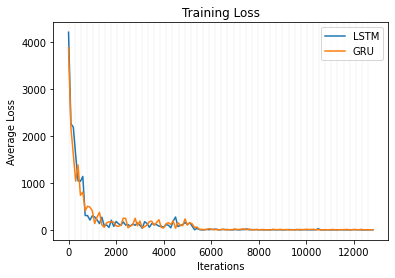

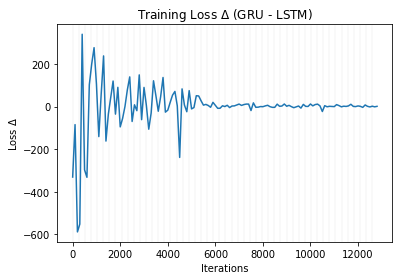

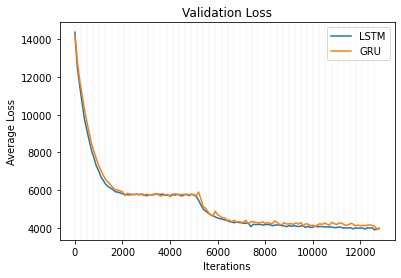

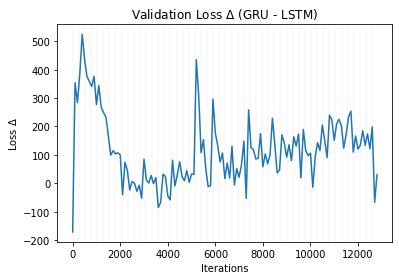

Final LSTM validation loss:3980.294921875
Final GRU validation loss:4064.122314453125


In [30]:
iters = list(range(1, epochs*len(trainloader), 100))

def epoch_lines():
    for x in range(0, iters[-1], len(trainloader)):
        plt.axvline(x=x, lw=0.05, c='black')

_, ax1 = plt.subplots()
ax1.plot(iters, lstm_loss)
ax1.plot(iters, gru_loss)
epoch_lines()
plt.title('Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Average Loss')
plt.legend(['LSTM','GRU'])
plt.show()

_, ax2 = plt.subplots()
ax2.plot(iters, [gru_loss[i]-lstm_loss[i] for i in range(len(lstm_loss))])
plt.title('Training Loss $\Delta$ (GRU - LSTM)')
epoch_lines()
plt.xlabel('Iterations')
plt.ylabel('Loss $\Delta$')
plt.show()

_, ax3 = plt.subplots()
ax3.plot(iters, lstm_val_loss)
ax3.plot(iters, gru_val_loss)
epoch_lines()
plt.title('Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Average Loss')
plt.legend(['LSTM','GRU'])
plt.show()

_, ax4 = plt.subplots()
ax4.plot(iters, [gru_val_loss[i]-lstm_val_loss[i] for i in range(len(lstm_val_loss))])
epoch_lines()
plt.title('Validation Loss $\Delta$ (GRU - LSTM)')
plt.xlabel('Iterations')
plt.ylabel('Loss $\Delta$')
plt.show()

lstm_eval = validate(lstm_net, testloader, model='LSTM')
gru_eval = validate(gru_net, testloader, model='GRU')

print('Final LSTM validation loss:{}'.format(lstm_eval))
print('Final GRU validation loss:{}'.format(gru_eval))


In [ ]:
'''
TODO:
get loss on test set and graph
fit the original stock curve
'''

In [15]:
'''
Dataset augmentation - ideas:
1. Use the open prices for stocks as a separate dataset
2. Add Gaussian Noise to the dataset
3. Run sequences backwards - market doesn't seem symmetrical though

Notes:
Stateful vs stateless?
What is causing the large jumps with epochs?
Variable learning rate
Tweak parameters and hyperparameters
Test multiple symbols at the same time
Tanh vs ReLU?
'''

[1, 3]
